Baseado em https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/



# Importa os pré-requisitos

In [ ]:
# import the necessary packages
import os
# import the necessary packages
from bs4 import BeautifulSoup
from imutils import paths
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define variáveis do ambiente

In [ ]:
#Limite das probabilidades - se for menor então considera que o objeto não está na imagem
THRESHOLD = 0.9

# Limite acima do qual considera que as caixas sobrepostas são o mesmo objeto
NMS_THRESHOLD = 0.15

#Número de classes
NRCLASSES = 15

#Nome da pasta
DATA_PATH="objetos-mesa"

#Dimensões da imagem que deve ser passada para a rede
INPUT_DIMS = (224, 224)
# define the path to the output model and label binarizer
MODEL_PATH = "object_detector.h5"
ENCODER_PATH = "label_encoder.pickle"
# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
MIN_PROBA = 0.99

#Variáveis para o treimanento
#Learning rate, qtdade de épocas e batch size
INIT_LR = 1e-4
EPOCHS = 100
BS = 16

MAX_PROPOSALS_INFER = 20

# Monta o google drive

In [ ]:
#Mount gdrive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ln -s gdrive/'My Drive'/'Object Detection Dataset'/'objetos-mesa' .

In [ ]:
!ls

drive  objetos-mesa  sample_data


# Carrega as imagens

In [ ]:
#Inicializa os vetores que vão ser usados no treinamento
data = []
labels = []
image_count = 0

#Lê o arquivo index.txt que tem os prefixos das imagens e das anotações
f = open(DATA_PATH + os.path.sep + 'index.txt')
for linha in f:
  #Tira o \n no final de cada linha
	linha = linha[:-1]  
	print("[INFO] processing image ", linha)
	# extract the filename from the file path and use it to derive
	# the path to the XML annotation file

  #nome do arquivo da imagem
	imgFilename = DATA_PATH + os.path.sep + linha + '.jpg'

  # para fazer testes em um conjunto menor de imagens 
  # descomente as linhas a seguir pois isso irá carregar
  # um conjunto menor de imagens (6 somente)
	#image_count = image_count + 1
	#if (image_count > 5):
	#	break

  #nome do arquivo da anotação
	annotFilename = DATA_PATH + os.path.sep + linha + '.xml'
	
	# load the annotation file, build the soup, and initialize our
	# list of ground-truth bounding boxes
	contents = open(annotFilename).read()
	soup = BeautifulSoup(contents, "html.parser")

	# extract the image dimensions
	w = int(soup.find("width").string)
	h = int(soup.find("height").string)
	
	#continue

	# loop over all 'object' elements
	for o in soup.find_all("object"):
		# extract the label and bounding box coordinates
		label = o.find("name").string
		xMin = int(o.find("xmin").string)
		yMin = int(o.find("ymin").string)
		xMax = int(o.find("xmax").string)
		yMax = int(o.find("ymax").string)
		# truncate any bounding box coordinates that may fall
		# outside the boundaries of the image
		xMin = max(0, xMin)
		yMin = max(0, yMin)
		xMax = min(w, xMax)
		yMax = min(h, yMax)
		
  	# load the input image (224x224) and preprocess it
		image = load_img(imgFilename, target_size=INPUT_DIMS)
		image = img_to_array(image)
		image = preprocess_input(image) # 
  
    # a imagem é lida em 224x224 então é preciso calcular as dimensões
    # dos objetos anotados dentro dessa nova proporção de imagem
		ratio_w0 = round(w / INPUT_DIMS[0])
		ratio_h0 = round(h / INPUT_DIMS[1])
		xMin0 = round(xMin / ratio_w0)
		xMax0 = round(xMax / ratio_w0)
		yMin0 = round(yMin / ratio_h0)
		yMax0 = round(yMax / ratio_h0) 

    # seleciona a parte da imagem onde o objeto anotado está
		obj_image = image[yMin0:yMax0, xMin0:xMax0]

    # a entrada da rede espera uma imagem 224x224 então redimensiona o objeto
		obj_resized = resize(obj_image, (INPUT_DIMS[0], INPUT_DIMS[1]))
		
		data.append(obj_resized)
		labels.append(label)


[INFO] processing image  IMG_20201024_195603
[INFO] processing image  IMG_20201024_195611
[INFO] processing image  IMG_20201024_195621
[INFO] processing image  IMG_20201024_195727
[INFO] processing image  IMG_20201024_195733
[INFO] processing image  IMG_20201024_195741
[INFO] processing image  IMG_20201024_195842
[INFO] processing image  IMG_20201024_195848
[INFO] processing image  IMG_20201024_195855
[INFO] processing image  IMG_20201024_200118
[INFO] processing image  IMG_20201024_200132
[INFO] processing image  IMG_20201024_200249
[INFO] processing image  IMG_20201024_200253
[INFO] processing image  IMG_20201024_200257
[INFO] processing image  IMG_20201024_200306
[INFO] processing image  IMG_20201024_200345
[INFO] processing image  IMG_20201024_200351
[INFO] processing image  IMG_20201024_200357
[INFO] processing image  IMG_20201024_200422
[INFO] processing image  IMG_20201024_200427
[INFO] processing image  IMG_20201024_200431
[INFO] processing image  IMG_20201024_200432
[INFO] pro

In [ ]:
print(labels[0])

maionese


In [ ]:
data[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


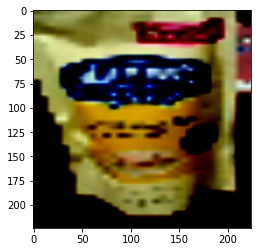

In [ ]:
plt.imshow(data[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


oleo
caixachocolate
agua
leite
pao
maionese
caixachocolate


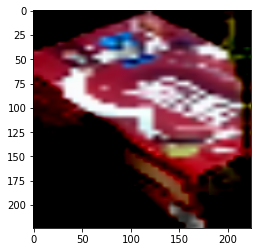

In [ ]:
for i in range(1,8):
  #print(i)
  print(labels[i])
  plt.imshow(data[i])

In [ ]:
# convert the data and labels to NumPy arrays
data_np = np.array(data, dtype="float32")
data_np.shape
labels_np = np.array(labels)
labels_np.shape
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels_b = lb.fit_transform(labels_np)
#Descomente a linha abaixo se o seu modelo só tem dois tipos de saída
#labels_b = to_categorical(labels_b)


In [ ]:
data_np.shape

(289, 224, 224, 3)

In [ ]:
labels_b.shape

(289, 15)

# Prepara o modelo

In [ ]:

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data_np, labels_b,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(NRCLASSES, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
# TODO Testar com outras camadas não congeladas
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


# Treina o modelo

In [ ]:

#usar variavel de cima
EPOCHS=100
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/100
14/14 [==============================] - 17s 944ms/step - loss: 3.5192 - accuracy: 0.0853 - val_loss: 2.7173 - val_accuracy: 0.0517
Epoch 2/100
14/14 [==============================] - 12s 841ms/step - loss: 3.0187 - accuracy: 0.1084 - val_loss: 2.4719 - val_accuracy: 0.1724
Epoch 3/100
14/14 [==============================] - 12s 863ms/step - loss: 2.7791 - accuracy: 0.1718 - val_loss: 2.2906 - val_accuracy: 0.3103
Epoch 4/100
14/14 [==============================] - 12s 856ms/step - loss: 2.4131 - accuracy: 0.2079 - val_loss: 2.1394 - val_accuracy: 0.4310
Epoch 5/100
14/14 [==============================] - 12s 884ms/step - loss: 2.2404 - accuracy: 0.2719 - val_loss: 2.0136 - val_accuracy: 0.5000
Epoch 6/100
14/14 [==============================] - 12s 862ms/step - loss: 2.1744 - accuracy: 0.3062 - val_loss: 1.9001 - val_accuracy: 0.5862
Epoch 7/100
14/14 [==============================] - 12s 841ms/step - loss: 2.0349 - a

# Mostra as informações do treinamento

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
                 precision    recall  f1-score   support

           agua       1.00      1.00      1.00         4
         banana       1.00      1.00      1.00         4
 caixachocolate       1.00      0.50      0.67         2
            cha       0.80      1.00      0.89         4
     detergente       0.80      1.00      0.89         4
         feijao       1.00      1.00      1.00         2
        fosforo       1.00      0.80      0.89         5
          leite       1.00      1.00      1.00         5
leitecondensado       0.83      1.00      0.91         5
       maionese       1.00      1.00      1.00         5
           oleo       1.00      1.00      1.00         5
            pao       1.00      1.00      1.00         4
           pera       1.00      1.00      1.00         3
   refrigerante       1.00      0.50      0.67         2
       sucoempo       1.00      1.00      1.00         4

       accuracy                           0.95        58


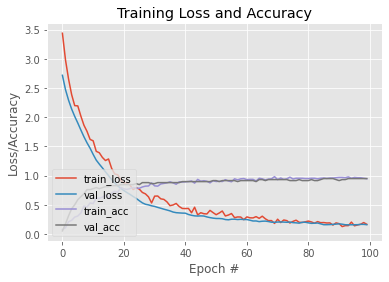

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
plt.savefig('saida')

# Salvo o modelo

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("modelo", save_format="h5")
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open("encoder", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...
[INFO] saving label encoder...


In [ ]:
!ls

drive  encoder	gdrive	modelo	objetos-mesa  saida.png  sample_data


In [ ]:
#TODO salvar o modelo com o nome do dia

In [ ]:
!cp modelo objetos-mesa/modelo-27abr2021
!cp encoder objetos-mesa/encoder-27abr2021

In [ ]:
!ls objetos-mesa/

encoder-27abr2021	 IMG_20201024_200306.jpg  IMG_20201024_200902.jpg
encoder-30mar2021	 IMG_20201024_200306.xml  IMG_20201024_200902.xml
IMG_20201024_195603.jpg  IMG_20201024_200345.jpg  IMG_20201024_200906.jpg
IMG_20201024_195603.xml  IMG_20201024_200345.xml  IMG_20201024_200906.xml
IMG_20201024_195611.jpg  IMG_20201024_200351.jpg  IMG_20201024_200935.jpg
IMG_20201024_195611.xml  IMG_20201024_200351.xml  IMG_20201024_200935.xml
IMG_20201024_195621.jpg  IMG_20201024_200357.jpg  IMG_20201024_200939.jpg
IMG_20201024_195621.xml  IMG_20201024_200357.xml  IMG_20201024_200939.xml
IMG_20201024_195727.jpg  IMG_20201024_200422.jpg  IMG_20201024_200944.jpg
IMG_20201024_195727.xml  IMG_20201024_200422.xml  IMG_20201024_200944.xml
IMG_20201024_195733.jpg  IMG_20201024_200427.jpg  IMG_20201024_201007.jpg
IMG_20201024_195733.xml  IMG_20201024_200427.xml  IMG_20201024_201007.xml
IMG_20201024_195741.jpg  IMG_20201024_200431.jpg  IMG_20201024_201011.jpg
IMG_20201024_195741.xml  IMG_20201024_200431.xml  

# Carrega o modelo

Essa parte e a seguinte podem ser separadas em um programa a parte quando for usado em produção e/ou uma competição.
Como o treinamento está sendo feito logo acima não existe realmente necessidade de carregar o modelo.

Execute a célula abaixo se quiser carregar um modelo antigo

In [ ]:
!cp objetos-mesa/modelo-30mar2021 modelo
!cp objetos-mesa/encoder-30mar2021 encoder

In [ ]:
!cat encoder

�csklearn.preprocessing._label
LabelBinarizer
   sparse_outputq�X   y_type_qX
   sparse_input_q�X   classes_q	cnumpy.core.multiarray
_reconstruct
q
cnumpy
ndarray
�qRq(KK�qcnumpy
dtype
qX   U15q���qRq(KX   <qNNNK<KKtqb�B�  a   g   u   a                                               b   a   n   a   n   a                                       c   a   i   x   a   c   h   o   c   o   l   a   t   e       c   h   a                                                   d   e   t   e   r   g   e   n   t   e                       f   e   i   j   a   o                                       f   o   s   f   o   r   o                                   l   e   i   t   e                                           l   e   i   t   e   c   o   n   d   e   n   s   a   d   o   m   a   i   o   n   e   s   e                               o   l   e   o                                               p   a   o                                                   p   e   r   a                     

In [ ]:
model = load_model("modelo")
lb = pickle.loads(open("encoder", "rb").read())

In [ ]:
print(type(lb))

<class 'sklearn.preprocessing._label.LabelBinarizer'>


In [ ]:
!pwd

/content


In [ ]:
!ls

drive  gdrive  objetos-mesa  sample_data


In [ ]:
!ls -lah objetos-mesa/*

-rw------- 1 root root  1.3K May 10 22:25 objetos-mesa/encoder-10mai2021
-rw------- 1 root root  1.3K May 27 01:03 objetos-mesa/encoder-26mai2021
-rw------- 1 root root  1.3K May 10 22:24 objetos-mesa/encoder-27abr2021
-rw------- 1 root root  1.3K Apr 20 21:23 objetos-mesa/encoder-30mar2021
-rw------- 1 root root  360K Oct 24  2020 objetos-mesa/IMG_20201024_195603.jpg
-rw------- 1 root root  1.7K Oct 27  2020 objetos-mesa/IMG_20201024_195603.xml
-rw------- 1 root root  418K Oct 24  2020 objetos-mesa/IMG_20201024_195611.jpg
-rw------- 1 root root  1.7K Oct 27  2020 objetos-mesa/IMG_20201024_195611.xml
-rw------- 1 root root  312K Oct 24  2020 objetos-mesa/IMG_20201024_195621.jpg
-rw------- 1 root root  1.5K Oct 27  2020 objetos-mesa/IMG_20201024_195621.xml
-rw------- 1 root root  233K Oct 24  2020 objetos-mesa/IMG_20201024_195727.jpg
-rw------- 1 root root  2.0K Oct 27  2020 objetos-mesa/IMG_20201024_195727.xml
-rw------- 1 root root  364K Oct 24  2020 objetos-mesa/IMG_20201024_195733.j

In [ ]:
!md5sum objetos-mesa/encoder*

4d8bdf0b7fb9599710d68e0612d09a1b  objetos-mesa/encoder-10mai2021
4d8bdf0b7fb9599710d68e0612d09a1b  objetos-mesa/encoder-26mai2021
4d8bdf0b7fb9599710d68e0612d09a1b  objetos-mesa/encoder-27abr2021
4d8bdf0b7fb9599710d68e0612d09a1b  objetos-mesa/encoder-30mar2021


# Carrega uma imagem como exemplo e faz a predição

In [ ]:
#banana
#test_filename = 'IMG_20201109_195321'

test_filename = 'IMG_20201024_195842'

#pao e detergente
#test_filename = 'IMG_20201024_200717'

#test_filename = 'IMG_20201024_201140'
test_img = load_img('/content/objetos-mesa/'+test_filename+'.jpg', target_size=INPUT_DIMS)

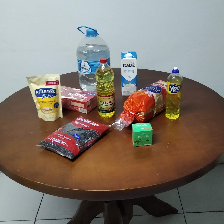

In [ ]:
test_img

In [ ]:
# Gera um vetor de entradas no qual será realizada a predição
test_img = img_to_array(test_img)
test_img = preprocess_input(test_img)
input_test = []

# TODO o ideal é preencher o vetor de entrada com porções da imagem
# assim podemos saber melhor onde estão localizados os objetos
# Sugestão: implementar o algoritmo de janela deslizante sobre a imagem
input_test.append(test_img)
input_test_np = np.array(input_test, dtype="float32")

# Salva as probabilidades para essa entrada em proba
proba = model.predict(input_test_np)

In [ ]:
proba

array([[0.16317862, 0.00285366, 0.00081435, 0.05154015, 0.03256238,
        0.02143542, 0.01904284, 0.03250761, 0.00173313, 0.00055708,
        0.05373564, 0.30649886, 0.02271619, 0.2703525 , 0.02047152]],
      dtype=float32)

In [ ]:
lb.classes_

array(['agua', 'banana', 'caixachocolate', 'cha', 'detergente', 'feijao',
       'fosforo', 'leite', 'leitecondensado', 'maionese', 'oleo', 'pao',
       'pera', 'refrigerante', 'sucoempo'], dtype='<U15')

In [ ]:
#Para o primeira imagem (posição 0) do vetor de entrada mostra
#as probabilidades caso elas sejam maiores do que o limite.
for prob_i, label_i in zip(proba[0], lb.classes_):
  if (prob_i > THRESHOLD):
    print(label_i, " ", prob_i)

agua   0.2330339
pao   0.14724182
refrigerante   0.5204118


Até aqui ele está tentando usar a imagem inteira como se tivesse um único objeto. Aparentemente ele dá o resultado referente ao maior objeto da imagem.

Entretanto na verdade é preciso adaptar o código para detectar vários objetos.

# Até aqui parece estar funcionando 

A partir daqui parece que tem um ou mais bugs no código. Proceda com cautela :P

# Testando com pedaços da imagem
Testando a detecção usando as partes da imagem que foram usadas no treinamento. Não é o ideal mas serve como um teste.
Parece que passando um pedaço da imagem ele detecta corretamente o objeto. O problema então seria descobrir onde estão os objetos na imagem.

In [ ]:
#Dado um vetor de probabilidades e os rótulos disponíveis retorna dois valores:
# a maior probabilidade e o respectivo rótulo
def max_prob_label(proba, labels):
  max_prob = 0
  max_label = ''

  for prob_i, label_i in zip(proba, labels):
    if (prob_i > max_prob):
      max_prob = prob_i
      max_label = label_i
  return [max_prob, max_label]


In [ ]:
data_np = np.array(data, dtype="float32")
data_np.shape

(289, 224, 224, 3)

In [ ]:
prob_test = model.predict(data_np)

In [ ]:
i = 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


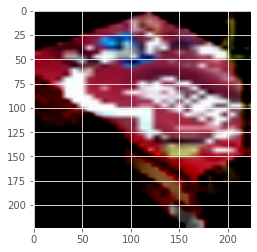

In [ ]:
plt.imshow(data[i])

In [ ]:
lb.classes_

array(['agua', 'banana', 'caixachocolate', 'cha', 'detergente', 'feijao',
       'fosforo', 'leite', 'leitecondensado', 'maionese', 'oleo', 'pao',
       'pera', 'refrigerante', 'sucoempo'], dtype='<U15')

In [ ]:
prob_test[i]

array([5.1652291e-03, 3.2637737e-04, 6.7573483e-04, 1.0236747e-02,
       9.7415708e-03, 2.1024630e-04, 8.5780770e-04, 9.4165719e-01,
       5.7154603e-04, 1.7602125e-02, 1.1274342e-02, 1.1806611e-04,
       4.8265402e-04, 9.0572838e-04, 1.7475786e-04], dtype=float32)

In [ ]:
max_prob_label(prob_test[i], lb.classes_)

[0.97897947, 'caixachocolate']

# Seletive search

O objetivo do algoritmo de SeletiveSearch é tentar detectar elementos de uma imagem que pode ser que sejam objetos, para isso ele usar mudanças de gradiante, variações de cores, etc. Isso é interessante pois é mais eficiente do que percorrer a imagem e tentar detectar objetos em toda a imagem (algoritmo de janela deslizante). Ao final então ele gera um conjunto de retângulos que possivelmente englobam objetos.

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

In [ ]:
rects.shape

(419, 4)

In [ ]:
rects[0]

array([142,  15,  16,  30], dtype=int32)

In [ ]:
type(rects)

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


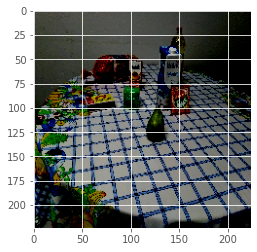

In [ ]:
#Mostra  a imagem original
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


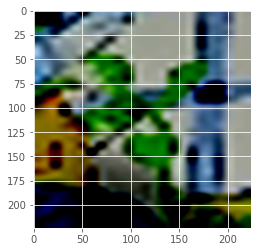

In [ ]:
#Pega um dos retângulos candidatos e mostra como ficou essa parte da imagem
# O tamanho máximo de i é dado na célula acima --> rects.shape
i = 200
[x,y,w,h]=rects[i]
roi = image[y:y + h, x:x + w]
#roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
roi = cv2.resize(roi, INPUT_DIMS,	interpolation=cv2.INTER_CUBIC)
plt.imshow(roi)

In [ ]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
count = 0
# loop over the region proposal bounding box coordinates generated by
# running selective search
for rect in rects:
	count = count + 1
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	

	[x, y, w, h] = rect
	roi = image[y:y + h, x:x + w]
	#roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
	# further preprocess the ROI
	#roi = img_to_array(roi)
	#roi = preprocess_input(roi)
	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

In [ ]:
proposals

[array([[[0.26509652, 0.26509652, 0.24941027],
         [0.26530072, 0.26530072, 0.24961446],
         [0.265357  , 0.265357  , 0.24967071],
         ...,
         [0.1973364 , 0.21476391, 0.19036387],
         [0.19741142, 0.21480143, 0.19042015],
         [0.19768368, 0.21493757, 0.19062436]],
 
        [[0.26509652, 0.26509652, 0.24941026],
         [0.26530072, 0.26530072, 0.24961446],
         [0.265357  , 0.265357  , 0.2496707 ],
         ...,
         [0.19738193, 0.21480943, 0.19040939],
         [0.19745694, 0.21484692, 0.19046566],
         [0.19772922, 0.21498308, 0.19066988]],
 
        [[0.26509655, 0.26509655, 0.24941027],
         [0.26530075, 0.26530075, 0.24961448],
         [0.26535696, 0.26535696, 0.24967071],
         ...,
         [0.19719476, 0.21462224, 0.19022222],
         [0.19726977, 0.21465978, 0.19027849],
         [0.19754204, 0.2147959 , 0.1904827 ]],
 
        ...,
 
        [[0.726428  , 0.7421142 , 0.73583865],
         [0.72720015, 0.7428865 , 0.73674

Pega as partes da imagem geradas na etapa anterior e para cada uma gera um vetor de probabilidades de quais objetos estão naquela parte da imagem.

In [ ]:

proposals_np = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals_np.shape))
# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals_np)

[INFO] proposal shape: (419, 224, 224, 3)
[INFO] classifying proposals...


Pega um dos objetos e tenta ver qual objeto tem mais chance de estar aparecendo na parte da imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


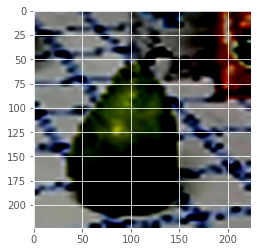

In [ ]:
i=1
plt.imshow(proposals[i])

In [ ]:
[tmp_prob, tmp_label] = max_prob_label(proba[i], lb.classes_)

In [ ]:
[tmp_prob, tmp_label]

[0.41214755, 'leite']

In [ ]:
proba

array([[4.09686305e-02, 7.88630825e-03, 2.19316278e-02, ...,
        1.14379942e-01, 2.19003074e-02, 2.59653274e-02],
       [1.75962123e-04, 1.65886851e-03, 2.35782878e-04, ...,
        9.67437923e-01, 1.13463460e-03, 5.34914841e-04],
       [6.08014688e-03, 8.54367332e-04, 5.24251089e-02, ...,
        3.43385781e-03, 7.09415600e-03, 2.99342796e-02],
       ...,
       [4.68601622e-02, 9.63994209e-03, 2.47756182e-03, ...,
        1.14593886e-01, 1.40976876e-01, 2.28049289e-02],
       [3.59978490e-02, 1.82464607e-02, 1.36897631e-03, ...,
        3.11759025e-01, 1.75247878e-01, 1.87505987e-02],
       [3.35450619e-02, 1.77732222e-02, 1.38225593e-03, ...,
        3.80275071e-01, 1.34571999e-01, 1.56209338e-02]], dtype=float32)

In [ ]:
scores = []
labels = []
for prob_i in proba:
  [tmp_prob, tmp_label] = max_prob_label(prob_i, lb.classes_)
  scores.append(tmp_prob)
  labels.append(tmp_label)

In [ ]:
scores

[0.39716357,
 0.8985949,
 0.54916596,
 0.40823525,
 0.4648072,
 0.43038988,
 0.7763083,
 0.26900274,
 0.2981726,
 0.24368447,
 0.24601988,
 0.57319087,
 0.42163903,
 0.47215214,
 0.22065742,
 0.2390121,
 0.38043508,
 0.29597196,
 0.25896227,
 0.29333678,
 0.22069299,
 0.16845845,
 0.31721067,
 0.23089713,
 0.13502467,
 0.25818095,
 0.23724088,
 0.45009443,
 0.29205728,
 0.13441454,
 0.4915233,
 0.25094682,
 0.39039907,
 0.15210436,
 0.203168,
 0.2503682,
 0.38259512,
 0.3619412,
 0.25530612,
 0.23888412,
 0.30096748,
 0.2575546,
 0.27580073,
 0.21534173,
 0.24978942,
 0.20759425,
 0.12028807,
 0.5980608,
 0.43058196,
 0.26254156,
 0.27292094,
 0.28300384,
 0.44474474,
 0.44615167,
 0.23889391,
 0.3390458,
 0.23035295,
 0.20796822,
 0.33741567,
 0.4884421,
 0.27155265,
 0.3265089,
 0.14741887,
 0.44544345,
 0.5896473,
 0.41720402,
 0.27451324,
 0.52869326,
 0.27425265,
 0.26002693,
 0.2813512,
 0.17013237,
 0.39862832,
 0.45975575,
 0.33737558,
 0.36964744,
 0.18974932,
 0.45018715,
 0.

index:  10 , prob:  0.5084661 , label:  pera , area:  182
index:  13 , prob:  0.552936 , label:  pera , area:  224
index:  16 , prob:  0.602015 , label:  pera , area:  180
index:  21 , prob:  0.5888553 , label:  pera , area:  140
index:  22 , prob:  0.6701131 , label:  pera , area:  154
index:  23 , prob:  0.73613894 , label:  pera , area:  225
index:  28 , prob:  0.69656175 , label:  pera , area:  165
index:  30 , prob:  0.674172 , label:  pera , area:  160
index:  46 , prob:  0.80339277 , label:  pera , area:  324
index:  63 , prob:  0.5130246 , label:  pera , area:  150
index:  64 , prob:  0.8281407 , label:  pera , area:  143
index:  67 , prob:  0.5919898 , label:  pera , area:  180
index:  73 , prob:  0.53307176 , label:  pera , area:  208
index:  78 , prob:  0.7507465 , label:  pera , area:  126
index:  92 , prob:  0.5285075 , label:  pera , area:  195
index:  94 , prob:  0.6428382 , label:  cha , area:  437
index:  100 , prob:  0.6534058 , label:  pera , area:  171
index:  101 ,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 pera , area:  154
index:  260 , prob:  0.6769271 , label:  pera , area:  240
index:  264 , prob:  0.57055604 , label:  pera , area:  143
index:  269 , prob:  0.8022893 , label:  pera , area:  198
index:  284 , prob:  0.6836626 , label:  pera , area:  225
index:  292 , prob:  0.61132824 , label:  pera , area:  345
index:  295 , prob:  0.5959604 , label:  pera , area:  182


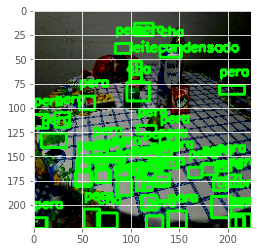

In [ ]:
from google.colab.patches import cv2_imshow
# clone the original image so that we can draw on it
clone = image.copy()
i = 0
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	i = i + 1
	
	y = startY - 10 if startY - 10 > 10 else startY + 10

	area = (endY - startY) * (endX - startX)
	#text= "Raccoon: {:.2f}%".format(prob * 100)
	#text="teste"
	[tmp_prob, tmp_label] = max_prob_label(prob, lb.classes_)
	text = tmp_label
	#print(tmp_prob)
	if (tmp_prob > 0.5 and area < 500):
	  print("index: ", i, ", prob: ", tmp_prob, ", label: ", tmp_label, ", area: ", area)
	  cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	  cv2.putText(clone, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

#clone = img_to_array(clone)
#clone = preprocess_input(clone)


# show the output after *before* running NMS
#imshow(clone)
plt.imshow(clone)

In [ ]:
#Código original dessa célula por Coutinho
def NMS(B, S, L, Nt, soft=False):
  D  = []
  Sd = []
  Ld = []

  B = list(B)
  S = list(S)
  L = list(L)

  while len(B) != 0:
    #B_S = list(zip(B, S))
    max_index = S.index(max(S))
    m = S[max_index] #sorted(B_S, key= lambda x: x[1],reverse=True)[0][1]
    M = B[max_index] #sorted(B_S, key= lambda x: x[1],reverse=True)[0][0]
    l = L[max_index]
    D.append(M)
    B.pop(max_index)
    Sd.append(m)
    S.pop(max_index)
    Ld.append(l)
    L.pop(max_index)
    index = -1
    for b in B:
      #index = B.index(b)
      if len(B) == 0:
        break;
      index = index + 1
      #print("index=",index)
      #print("M=",M)
      #print("b=",b)
      if soft:
        S[index] -= IOU(M['box'],b)['box']
      else:
        #if IOU(M['box'],b['box']) > Nt:
        if IOU(M, b) > Nt:
          B.pop(index)
          S.pop(index)
          L.pop(index)

  return D, Sd, Ld

def IOU(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
  # boxA= (boxA[0],boxA[1], boxA[0] + width, boxA[1] + height)
  # boxB= (boxB[0],boxB[1], boxB[0] + width, boxB[1] + height)
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou
     



In [ ]:
#NMS_THRESHOLD = 0.15
#THRESHOLD = 0.9

In [ ]:
selected_boxes, selected_scores, selected_labels = NMS(boxes, scores, labels, NMS_THRESHOLD)

In [ ]:
print(len(selected_boxes))

111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sucoempo 100%
pera 98%
pao 98%
fosforo 96%
leite 95%
cha 92%


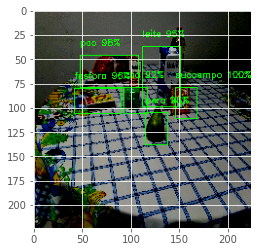

In [ ]:
clone2 = image.copy()
#selected_boxes = non_max_suppression_slow(boxes, 0.8)
# loop over the bounding box indexes
for tmp_box, tmp_score, tmp_label in zip(selected_boxes, selected_scores, selected_labels):
	#print(tmp_box, tmp_score)
	#continue
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = tmp_box
	if tmp_score < THRESHOLD:
		continue
	cv2.rectangle(clone2, (startX, startY), (endX, endY),
		(0, 255, 0), 1)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= tmp_label + " {:.0f}%".format(tmp_score * 100)
	print(text)
	cv2.putText(clone2, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
# show the output image *after* running NMS
#cv2.imshow("After NMS", image)
plt.imshow(clone2)

In [ ]:
clone_resized = cv2.resize(clone2, (800,800))

In [ ]:
cv2.imwrite('saida.jpg', clone_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])

True

In [ ]:
!ls

drive  encoder	gdrive	modelo	objetos-mesa  saida.png  sample_data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


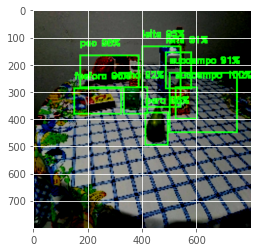

In [ ]:
plt.imshow(clone_resized)

Não execute código abaixo dessa linha ... a princípio não está funcionando

In [ ]:
def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]
    		# loop over all indexes in the indexes list
		for pos in range(0, last):
			# grab the current index
			j = idxs[pos]
			#print(j)
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]
	#return idxs

In [ ]:
boxes.shape

(305, 4)

In [ ]:
boxIdxs = non_max_suppression_slow(boxes, 0.3)

In [ ]:
print(boxIdxs)

[[  0  65 224 224]
 [196  11 224  82]
 [ 67  33 109  77]
 [155  43 183  55]
 [ 64   0  85  10]]


In [ ]:
def find_labels(boxIdxs, boxes, proba):
  tmp_labels = []
  for b_i in boxIdxs:
    #print(b_i)
    for b_j, prob_j in zip(boxes, proba):
      if (b_i[0] == b_j[0] and b_i[1] == b_j[1]  and b_i[2] == b_j[2]  and b_i[3] == b_j[3]):
        tmp_label = max_prob_label(prob_j, lb.classes_)
        #print(tmp_label)
        tmp_labels.append(tmp_label)
        break
  return tmp_labels


In [ ]:
print(lb.classes_)

['agua' 'banana' 'caixachocolate' 'cha' 'detergente' 'feijao' 'fosforo'
 'leite' 'leitecondensado' 'maionese' 'oleo' 'pao' 'pera' 'refrigerante'
 'sucoempo']


In [ ]:
print(proba[3])

[0.02707874 0.03221949 0.04405431 0.040933   0.19834368 0.02052372
 0.07923278 0.1412155  0.07235695 0.00547327 0.02504686 0.04057581
 0.107503   0.07689246 0.08855056]


In [ ]:
labels_after_nms = find_labels(boxIdxs, boxes, proba)

In [ ]:
labels_after_nms

[[0.19563779, 'sucoempo'],
 [0.5517264, 'pera'],
 [0.24402809, 'pera'],
 [0.30023518, 'leite'],
 [0.3113449, 'pera'],
 [0.3250458, 'detergente'],
 [0.58472496, 'pao'],
 [0.4347448, 'pera'],
 [0.4223291, 'pera']]